In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
plays = pd.read_csv('data/lastfm/user_artists.dat', sep='\t')
artists = pd.read_csv('data/lastfm/artists.dat', sep='\t', 
usecols=['id','name'])


# Merge artist and user pref data
ap = pd.merge(artists, plays, how="inner", left_on="id", right_on="artistID")
ap = ap.rename(columns={"weight": "playCount"})

# Group artist by name
artist_rank = ap.groupby(['name']) \
    .agg({'userID' : 'count', 'playCount' : 'sum'}) \
    .rename(columns={"userID" : 'totalUsers', "playCount" : "totalPlays"}) \
    .sort_values(['totalPlays'], ascending=False)
artist_rank['avgPlays'] = artist_rank['totalPlays'] / artist_rank['totalUsers']
print(artist_rank)

                    totalUsers  totalPlays     avgPlays
name                                                   
Britney Spears             522     2393140  4584.559387
Depeche Mode               282     1301308  4614.567376
Lady Gaga                  611     1291387  2113.563011
Christina Aguilera         407     1058405  2600.503686
Paramore                   399      963449  2414.659148
...                        ...         ...          ...
Morris                       1           1     1.000000
Eddie Kendricks              1           1     1.000000
Excess Pressure              1           1     1.000000
My Mine                      1           1     1.000000
A.M. Architect               1           1     1.000000

[17632 rows x 3 columns]


In [3]:
# Merge into ap matrix
ap = ap.join(artist_rank, on="name", how="inner") \
    .sort_values(['playCount'], ascending=False)

# Preprocessing
pc = ap.playCount
play_count_scaled = (pc - pc.min()) / (pc.max() - pc.min())
ap = ap.assign(playCountScaled=play_count_scaled)


# Build a user-artist rating matrix 
ratings_df = ap.pivot(index='userID', columns='artistID', values='playCountScaled')
ratings = ratings_df.fillna(0).values

# Show sparsity
sparsity = float(len(ratings.nonzero()[0])) / (ratings.shape[0] * ratings.shape[1]) * 100
print("sparsity: %.2f" % sparsity)

sparsity: 0.28


In [6]:
from scipy.sparse import csr_matrix

# Build a sparse matrix
X = csr_matrix(ratings)

n_users, n_items = ratings_df.shape
print("rating matrix shape", ratings_df.shape)

user_ids = ratings_df.index.values
artist_names = ap.sort_values("artistID")["name"].unique()

rating matrix shape (1892, 17632)


In [7]:
from lightfm import LightFM
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
from lightfm.cross_validation import random_train_test_split
from lightfm.data import Dataset

# Build data references + train test
Xcoo = X.tocoo()
data = Dataset()
data.fit(np.arange(n_users), np.arange(n_items))
interactions, weights = data.build_interactions(zip(Xcoo.row, Xcoo.col, Xcoo.data)) 
train, test = random_train_test_split(interactions)

# Ignore that (weight seems to be ignored...)
# train = train_.tocsr()
# test = test_.tocsr()
# train[train==1] = X[train==1]
# test[test==1] = X[test==1]

# To be completed...

/opt/anaconda3/envs/machinelearning/lib/python3.8/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [6]:
# Train
def model():
    param_loss= ["warp", "bpr", "warp-kos", "logistic"]
    score= []
    for i in param_loss:
    
        model = LightFM(learning_rate=0.05, loss=i)
        model.fit(train, epochs=10, num_threads=2)
        train_precision = precision_at_k(model, train, k=10).mean()
        test_precision = precision_at_k(model, test, k=10, train_interactions=train).mean()
    
        train_auc = auc_score(model, train).mean()
        test_auc = auc_score(model, test, train_interactions=train).mean()
        
        train_recall = recall_at_k(model, train).mean()
        test_recall = recall_at_k(model, test).mean()
        
        score_ = [train_precision, test_precision, train_auc, test_auc, train_recall, test_recall]
        score.append(score_)
        scores = np.array(score)
    score_final = pd.DataFrame(scores,
                        columns = ["train_precision", "test_precision", "train_auc",
                                   "test_auc", "train_recall", "test_recall"],
                        index  = ["warp", "bpr", "warp-kos", "logistic"])
    scores = model.predict(0, np.arange(n_items))
    top_items = artist_names[np.argsort(-scores)]
    print('top_items :',top_items)
    return score_final

In [7]:
model()

top_items : ['Lady Gaga' 'Britney Spears' 'Katy Perry' ... 'Yppah'
 'Luigi Dallapiccola' 'Nexilva']


,train_precision,test_precision,train_auc,test_auc,train_recall,test_recall
warp,0.376312,0.126467,0.965942,0.855147,0.096608,0.083378
bpr,0.373503,0.121451,0.848417,0.780363,0.096241,0.077773
warp-kos,0.352994,0.124280,0.889002,0.818090,0.091035,0.080981
logistic,0.200530,0.066756,0.887550,0.804180,0.051943,0.049098


### fonction get_recommendations

In [8]:
indices = pd.Series(artist_rank['avgPlays'], index=artist_rank.index).drop_duplicates()

In [9]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity

# Compute the cosine similarity matrix

cosine_sim = cosine_similarity(train, train)
#on le fait pour avoir une dimension de(45466,45466) au lieu de(45466,75827)qui(nbfilm,nbmots)
print(cosine_sim.shape)

(1892, 1892)


In [10]:
from time import time
def get_recommendations(userID):
    start = time()
    Artists = []
    dic = {}
    ind = []
    liste_ = []
    # Get the index of the movie that matches the title
    idx = list(plays.artistID[plays['userID']==userID])#indices[title]
    #print("idx=",[idx.head(5)])
    for item in idx:
        #calculer cosine_similarity (vecteur * matrice)
        #cosine_sim = cosine_similarity(train, tfidf_matrix[idx])

        # Get the pairwsie similarity scores of all movies with that movie
        sim_scores = list(enumerate(cosine_sim[item]))

        # Sort the movies based on the similarity scores
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

        # Get the scores of the 10 most similar movies
        sim_scores = sim_scores[1:11]

        # Get the movie indices
        user_indices = [i[0] for i in sim_scores]
        ind.append(user_indices[0])
        #print(movie_indices[0])
    #print(ind)
    for each in ind:
        p = (artists[artists.id == each]).values
#        print("p",p[0][1])
        Artists.append(p[0][1])
#     print("Artists",Artists)
    for k,v in indices.items():
        for j in Artists:
            if j in str(k):
                dic[j]=v
    liste=sorted(dic.items(), key=lambda t: t[1], reverse=True)
#     print(LISTE)
    for arg, num in liste:
        liste_.append(arg)
#     print("sorted", liste_)
    times = time()-start
    times = round(times,3)
    print("Time = {} secondes".format(times))
    # Return the top 10 most similar movies
    #return  "liste des indexs des artistes = {}".format(ind), "liste = {}".format(L[0:11])
    return  liste_[1:11]

In [11]:
get_recommendations(9)

Time = 0.198 secondes


['Led Zeppelin',
 'nevershoutnever!',
 'Atreyu',
 'Skinny Puppy',
 'The Strollers',
 'Đorđe Balašević',
 'Jonathan Larson',
 '雅-MIYAVI-',
 'Skillet',
 'Röyksopp']

### Comparatif des résultat de l'AUC avec TruncatedSvd

In [12]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=0)

svd_matrix = svd.fit_transform(X)
svd_matrix.shape



(1892, 100)

In [13]:
pred = svd_matrix[0].dot(svd.components_[:, 0])
print(pred)

5.639471188270382e-06


### Nombre d'itération pour la convergence du model

In [14]:
model = LightFM(learning_rate= 0.05, loss='warp', random_state=0)
log_model = []
for i in range(1, 50):
    model.fit_partial(train, epochs = 1)
    log_model.append(auc_score(model, train).mean())

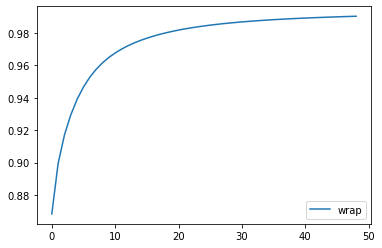

In [15]:
plt.plot(np.array(log_model))
plt.legend(['wrap'], loc = 'lower right')

On remarque que pour 95% on est as 7 itérations

### optimization des hyper-paramètres 

In [16]:
from sklearn.model_selection import ParameterGrid
param_grid = {
    'learning_rate': [0.05 , 0.08],
    'learning_schedule':['adagrad','adadelta'],
    'loss': ['warp','bpr','logistic','warp-kos'],
    'k':[1, 5, 6, 10], 
    'n' : [1, 5, 6, 10]
    
       
} # Create a based model

list(ParameterGrid(param_grid))
auc_score_values = []

for grid in ParameterGrid(param_grid):
    model = LightFM(**grid) # ** pour récuperer les parm_grid
    pred = model.fit(train)
    auc_score_values.append(round(auc_score(model, test, train_interactions=train).mean(),3))

max_value = max(auc_score_values) 
max_index = np.argmax(auc_score_values)
ParameterGrid(param_grid)[max_index ].items()

dict_items([('n', 1), ('loss', 'warp'), ('learning_schedule', 'adadelta'), ('learning_rate', 0.05), ('k', 1)])